### Models Comparison

This code is part our research on malware detection and classification using Deep Learning and Deep Graph Convolutional Neural Networks.

For more information or citation, please refer to our research paper:

"Oliveira, Angelo; Sassi, Renato José (2019): Behavioral Malware Detection Using Deep Graph Convolutional Neural Networks. TechRxiv. Preprint." at https://doi.org/10.36227/techrxiv.10043099.v1

For the dataset, please refer to our repository: 

https://ieee-dataport.org/open-access/malware-analysis-datasets-api-call-sequences

#### Balanced Dataset

In [ ]:
import numpy as np
SEED = 137
np.random.seed(SEED)

import time
from collections import Counter

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.metrics import precision_score, f1_score, roc_auc_score, roc_curve
from sklearn import decomposition

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import torch
torch.manual_seed(SEED)
import torch.nn as nn
import torch.nn.functional as F

from skorch.classifier import NeuralNetBinaryClassifier

import matplotlib.pyplot as plt
from matplotlib import pyplot

### Data Preprocessing

In [ ]:
df = pd.read_csv('dynamic_api_call_sequence_per_malware_100_0_306.csv')
df.head()

hash  t_0  t_1  t_2  t_3  t_4  t_5  t_6  t_7  \
0  071e8c3f8922e186e57548cd4c703a5d  112  274  158  215  274  158  215  298   
1  33f8e6d08a6aae939f25a8e0d63dd523   82  208  187  208  172  117  172  117   
2  b68abd064e975e1c6d5f25e748663076   16  110  240  117  240  117  240  117   
3  72049be7bd30ea61297ea624ae198067   82  208  187  208  172  117  172  117   
4  c9b3700a77facf29172f32df6bc77f48   82  240  117  240  117  240  117  240   

   t_8  ...  t_91  t_92  t_93  t_94  t_95  t_96  t_97  t_98  t_99  malware  
0   76  ...    71   297   135   171   215    35   208    56    71        1  
1  172  ...    81   240   117    71   297   135   171   215    35        1  
2  240  ...    65   112   123    65   112   123    65   113   112        1  
3  172  ...   208   302   208   302   187   208   302   228   302        1  
4  117  ...   209   260    40   209   260   141   260   141   260        1  

[5 rows x 102 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43876 entries, 0 to 43875
Columns: 102 entries, hash to malware
dtypes: int64(101), object(1)
memory usage: 34.1+ MB


In [ ]:
X = df.drop(['hash', 'malware'], axis = 1).values.astype(int)
y = df['malware'].values.astype(int)
print(X.shape)
print(y.shape)

(43876, 100)
(43876,)


In [ ]:
print(X.min())
print(X.max())

0
306


In [ ]:
def check_imbalance(dataset):
    count = sorted(Counter(dataset).items())
    print(count)
    print(count[1][1] / count[0][1])
    return

In [ ]:
check_imbalance(y)

[(0, 1079), (1, 42797)]
39.66357738646895


In [ ]:
random_undersampler = RandomUnderSampler(random_state = SEED)

X, y = random_undersampler.fit_resample(X, y)

check_imbalance(y)

[(0, 1079), (1, 1079)]
1.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = SEED)

In [ ]:
check_imbalance(y_train)
check_imbalance(y_test)

del df, X, y

[(0, 738), (1, 772)]
1.046070460704607
[(0, 341), (1, 307)]
0.9002932551319648


### Models

#### DGCNN

In [ ]:
def norn_adj(X, input_dim_1):
    
    A = torch.zeros((X.size(0), input_dim_1, input_dim_1), dtype = torch.float).cuda()
        
    A_view = A.view(A.size(0), -1)
    x_size = X.size(-1)
    indices = X.narrow(-1, 0, x_size - 1) * A.stride(1) * A.stride(2) + X.narrow(-1, 1, x_size - 1) * A.stride(2)
    A_view.scatter_(1, indices, 1)
        
    A_hat = A + torch.eye(input_dim_1, dtype = torch.float).cuda()
    D_hat = A_hat.sum(dim = 1).pow(-1.0).diag_embed()
    
    return A_hat, D_hat

def to_one_hot(X, input_dim_1):
    
    X = F.one_hot(X, num_classes = input_dim_1).float()    
    X = X.permute(0, 2, 1)
    
    return X

class DGCNN_network(nn.Module):
    
    def __init__(self, weight_dim_1, weight_dim_2):

        super(DGCNN_network, self).__init__()
        self.weight_dim_1 = weight_dim_1
        self.weight_dim_2 = weight_dim_2        
        self.weights = nn.Parameter(torch.rand((self.weight_dim_1, weight_dim_2), dtype = torch.float, requires_grad = True))
        
    def forward(self, A_hat, D_hat, X):
        return D_hat.matmul(A_hat).matmul(X).matmul(self.weights)

#### Model-1

In [ ]:
H_list_model_1 = []

class Model_1_network(nn.Module):
    
    def __init__(self, input_dim_1, input_dim_2, weight_dim_2, dropout_rate):
        
        super(Model_1_network, self).__init__()
        
        self.input_dim_1 = input_dim_1
        self.input_dim_2 = input_dim_2
        self.weight_dim_1 = input_dim_2
        self.weight_dim_2 = weight_dim_2
        self.dropout_rate = dropout_rate
        
        self.dgcnn = DGCNN_network(self.weight_dim_1, self.weight_dim_2)
        self.dropout = nn.Dropout(p = self.dropout_rate)
        self.fc = nn.Linear(self.input_dim_1 * self.weight_dim_2, 1)
        
    def forward(self, X):
        
        A_hat, D_hat = norn_adj(X, input_dim_1)
        X = to_one_hot(X, input_dim_1)

        H = self.dgcnn(A_hat, D_hat, X)
        H = self.dropout(H)
        H = torch.relu(H)
        H = H.view(H.size(0), -1)
        
        # Visualization
        if not self.training:
            H_list_model_1.append(H.cpu())        
        
        H = self.fc(H)
                
        return H.squeeze()

#### Model-2

In [ ]:
H_list_model_2 = []

class Model_2_network(nn.Module):
    
    def __init__(self, input_dim_1, input_dim_2, weight_dim_2, weight_dim_4, dropout_rate):
    
        super(Model_2_network, self).__init__()
        
        self.input_dim_1 = input_dim_1
        self.input_dim_2 = input_dim_2
        self.weight_dim_1 = input_dim_2
        self.weight_dim_2 = weight_dim_2
        self.weight_dim_3 = weight_dim_2
        self.weight_dim_4 = weight_dim_4
        self.dropout_rate = dropout_rate
        
        self.dgcnn_1 = DGCNN_network(self.weight_dim_1, self.weight_dim_2)
        self.dropout = nn.Dropout(p = self.dropout_rate)
        self.dgcnn_2 = DGCNN_network(self.weight_dim_3, self.weight_dim_4)
        self.fc = nn.Linear(self.input_dim_1 * (self.weight_dim_2 + self.weight_dim_4), 1)
        
    def forward(self, X):
        
        A_hat, D_hat = norn_adj(X, input_dim_1)
        X = to_one_hot(X, input_dim_1)        

        H_1 = self.dgcnn_1(A_hat, D_hat, X)
        H_1 = self.dropout(H_1)
        H_1 = torch.relu(H_1)
        H_2 = self.dgcnn_2(A_hat, D_hat, H_1)
        H_2 = self.dropout(H_2)
        H_2 = torch.relu(H_2)
        H_2 = torch.cat([H_1, H_2], 2)
        H_2 = H_2.view(H_2.size(0), -1)

        # Visualization
        if not self.training:
            H_list_model_2.append(H_2)   
        
        H_2 = self.fc(H_2)
                
        return H_2.squeeze()

#### LSTM

In [ ]:
H_list_lstm = []

class LSTM_network(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, dropout_rate):
        
        super(LSTM_network, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.dropout_rate = dropout_rate
        
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, batch_first = True)
        self.dropout = nn.Dropout(p = self.dropout_rate)
        self.fc = nn.Linear(self.hidden_dim, 1)
        
    def forward(self, X):
        
        X = F.one_hot(X, num_classes = self.input_dim).float().cuda()
        
        # Hidden layer shape: (num_layers, batch_size, hidden_dim)
        hidden_0 = (torch.zeros(1, X.size(0), self.hidden_dim).float().cuda(),
                    torch.zeros(1, X.size(0), self.hidden_dim).float().cuda())
        
        # Input/Output shape: (batch_size, seq_len, input_dim)
        _, self.hidden = self.lstm(X, hidden_0)
                
        H = self.hidden[0].squeeze()
        H = self.dropout(H)
        
        # Visualization
        if not self.training:
            H_list_lstm.append(H)           
        
        H = self.fc(H)
                
        return H.squeeze()

### Evaluation

In [ ]:
def model_evaluate(y, pred):
    print('Confusion matrix\n[TN FP]\n[FN TP]')
    print(confusion_matrix(y >= 0.5, pred >= 0.5))
    print(f'Accuracy: {accuracy_score(y >= 0.5, pred >= 0.5):.4f}')
    print(f'Precision: {precision_score(y >= 0.5, pred >= 0.5):.4f}')
    print(f'Recall: {recall_score(y >= 0.5, pred >= 0.5):.4f}')
    print(f'F1-Score: {f1_score(y >= 0.5, pred >= 0.5):.4f}')
    print(f'ROC AUC: {roc_auc_score(y, pred):.4f}')
    return

#### LSTM

In [ ]:
torch.manual_seed(SEED)

input_dim = 307
hidden_dim = 10
dropout_rate = 0.4
batch_size = 32
max_epochs = 30

LSTM = NeuralNetBinaryClassifier(
    LSTM_network,
    module__input_dim = input_dim,
    module__hidden_dim = hidden_dim,
    module__dropout_rate = dropout_rate,
    batch_size = batch_size,
    max_epochs = max_epochs,
    train_split = None,
    optimizer = torch.optim.Adam,
    iterator_train__shuffle = True,
    device = 'cuda'
)

pipe = Pipeline([
    ('model', LSTM)
])

pipe.fit(X_train, y_train.astype(np.float))

  epoch    train_loss     dur
-------  ------------  ------
      1        0.6664  0.3884
      2        0.5257  0.1893
      3        0.4366  0.1734
      4        0.4106  0.1733
      5        0.3575  0.1728
      6        0.3386  0.1733
      7        0.3072  0.1744
      8        0.3523  0.1737
      9        0.3200  0.1759
     10        0.6659  0.1748
     11        0.3816  0.1737
     12        0.3830  0.1705
     13        0.3078  0.1736
     14        0.2816  0.1730
     15        0.2746  0.1730
     16        0.2595  0.1729
     17        0.2463  0.1726
     18        0.2186  0.1687
     19        0.2099  0.1696
     20        0.1955  0.1705
     21        0.1932  0.1735
     22        0.2224  0.1719
     23        0.1950  0.1731
     24        0.1703  0.1710
     25        0.1659  0.1704
     26        0.1553  0.1725
     27        0.1501  0.1720
     28        0.1463  0.1716
     29        0.1568  0.1719
     30        0.1236  0.1721


Pipeline(memory=None,
         steps=[('model',
                 <class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=LSTM_network(
    (lstm): LSTM(307, 10, batch_first=True)
    (dropout): Dropout(p=0.4, inplace=False)
    (fc): Linear(in_features=10, out_features=1, bias=True)
  ),
))],
         verbose=False)

In [ ]:
H_list_lstm.clear()

X_test_predictions_1 = pipe.predict_proba(X_test)
model_evaluate(y_test, np.ones(len(y_test)))
model_evaluate(y_test, X_test_predictions_1)

Confusion matrix
[TN FP]
[FN TP]
[[  0 341]
 [  0 307]]
Accuracy: 0.4738
Precision: 0.4738
Recall: 1.0000
F1-Score: 0.6429
ROC AUC: 0.5000
Confusion matrix
[TN FP]
[FN TP]
[[288  53]
 [ 45 262]]
Accuracy: 0.8488
Precision: 0.8317
Recall: 0.8534
F1-Score: 0.8424
ROC AUC: 0.9270


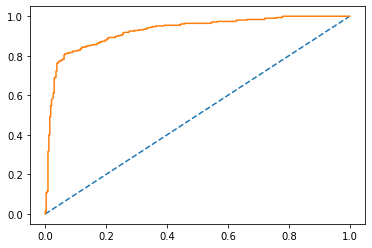

In [ ]:
fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, X_test_predictions_1)
pyplot.plot([0, 1], [0, 1], linestyle='--')
pyplot.plot(fpr_1, tpr_1)
pyplot.show()

In [ ]:
def visualize(X, y, points, n_features):
    points = np.arange(points)
    np.random.shuffle(points)
    color = ['red' if l == 1 else 'green' for l in y[points]]
    for i in range(n_features):
        for j in range(n_features):
            if j > i:
                plt.scatter(X[points, i], X[points, j], color = color)
                plt.pause(0.1)
                # plt.savefig('test.pdf')
                # plt.clf()
                print('*')
    return

In [ ]:
def visualize_pca(X, y):
    X = X / np.max(X)
    pca = decomposition.PCA(n_components = 2)
    visualize(pca.fit_transform(X), y, X.shape[0], 2)
    return

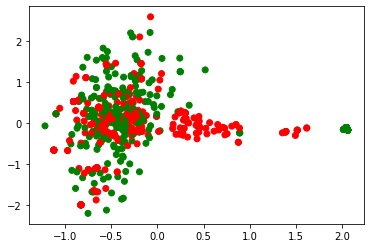

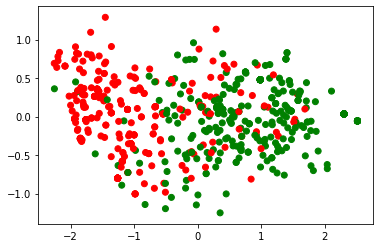

In [ ]:
# visualize_pca(X_test, y_test)

X = X_test / np.max(X_test)
pca = decomposition.PCA(n_components = 2)
X = pca.fit_transform(X)
points = np.arange(X.shape[0])
plt.scatter(X[points, 0], X[points, 1], color = ['red' if l == 1 else 'green' for l in y_test[points]])
plt.savefig('test_1.pdf')
plt.show()

result = torch.zeros(1, 10)

for i in H_list_lstm:
    result = torch.cat([result, i.cpu()], 0)

X_result = result.numpy()[1:]

X = X_result / np.max(X_result)
pca = decomposition.PCA(n_components = 2)
X = pca.fit_transform(X)
points = np.arange(X.shape[0])
plt.scatter(X[points, 0], X[points, 1], color = ['red' if l == 1 else 'green' for l in y_test[points]])
plt.savefig('test_2.pdf')
plt.show()

#### Model-1

In [ ]:
torch.manual_seed(SEED)

input_dim_1 = 307
input_dim_2 = 100
weight_dim_2 = 31
dropout_rate = 0.6
batch_size = 32
max_epochs = 30

model_1 = NeuralNetBinaryClassifier(
    Model_1_network,
    module__input_dim_1 = input_dim_1,
    module__input_dim_2 = input_dim_2,    
    module__weight_dim_2 = weight_dim_2,
    module__dropout_rate = dropout_rate,
    batch_size = batch_size,
    max_epochs = max_epochs,
    train_split = None,
    optimizer = torch.optim.Adam,
    iterator_train__shuffle = True,
    device = 'cuda'
)

pipe = Pipeline([
    ('model', model_1)
])

pipe.fit(X_train, y_train.astype(np.float))

  epoch    train_loss     dur
-------  ------------  ------
      1        1.1504  0.2666
      2        0.6027  0.2609
      3        0.4694  0.2727
      4        0.2702  0.2848
      5        0.2184  0.3111
      6        0.1627  0.2610
      7        0.1275  0.2623
      8        0.1031  0.2603
      9        0.1015  0.2603
     10        0.0937  0.2618
     11        0.0960  0.2616
     12        0.0840  0.2613
     13        0.0801  0.2623
     14        0.0682  0.2624
     15        0.0582  0.2649
     16        0.0599  0.2609
     17        0.0603  0.2608
     18        0.0582  0.2619
     19        0.0499  0.2670
     20        0.0559  0.2633
     21        0.0520  0.2604
     22        0.0518  0.2611
     23        0.0434  0.2609
     24        0.0527  0.2629
     25        0.0431  0.2601
     26        0.0441  0.2615
     27        0.0470  0.2615
     28        0.0522  0.2608
     29        0.0398  0.2612
     30        0.0459  0.2622


Pipeline(memory=None,
         steps=[('model',
                 <class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=Model_1_network(
    (dgcnn): DGCNN_network()
    (dropout): Dropout(p=0.6, inplace=False)
    (fc): Linear(in_features=9517, out_features=1, bias=True)
  ),
))],
         verbose=False)

In [ ]:
H_list_model_1.clear()

X_test_predictions_2 = pipe.predict_proba(X_test)
model_evaluate(y_test, np.ones(len(y_test)))
model_evaluate(y_test, X_test_predictions_2)

Confusion matrix
[TN FP]
[FN TP]
[[  0 341]
 [  0 307]]
Accuracy: 0.4738
Precision: 0.4738
Recall: 1.0000
F1-Score: 0.6429
ROC AUC: 0.5000
Confusion matrix
[TN FP]
[FN TP]
[[305  36]
 [ 22 285]]
Accuracy: 0.9105
Precision: 0.8879
Recall: 0.9283
F1-Score: 0.9076
ROC AUC: 0.9684


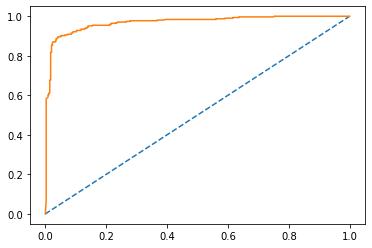

In [ ]:
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, X_test_predictions_2)
pyplot.plot([0, 1], [0, 1], linestyle='--')
pyplot.plot(fpr_2, tpr_2)
pyplot.show()

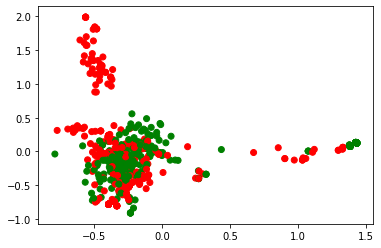

In [ ]:
result = torch.zeros(1, 9517)

for i in H_list_model_1:
    result = torch.cat([result, i.cpu()], 0)

X_result = result.numpy()[1:]

X = X_result / np.max(X_result)
pca = decomposition.PCA(n_components = 2)
X = pca.fit_transform(X)
points = np.arange(X.shape[0])

plt.scatter(X[points, 0], X[points, 1], color = ['red' if l == 1 else 'green' for l in y_test[points]])
plt.savefig('test_3.pdf')
plt.show()

#### Model-2

In [ ]:
torch.manual_seed(SEED)

input_dim_1 = 307
input_dim_2 = 100
weight_dim_2 = 71
weight_dim_4 = 17
dropout_rate = 0.6
batch_size = 32
max_epochs = 30

model_2 = NeuralNetBinaryClassifier(
    Model_2_network,
    module__input_dim_1 = input_dim_1,
    module__input_dim_2 = input_dim_2,    
    module__weight_dim_2 = weight_dim_2,
    module__weight_dim_4 = weight_dim_4,
    module__dropout_rate = dropout_rate,
    batch_size = batch_size,
    max_epochs = max_epochs,
    train_split = None,
    optimizer = torch.optim.Adam,
    iterator_train__shuffle = True,
    device = 'cuda'
)

pipe = Pipeline([
    ('model', model_2)
])

pipe.fit(X_train, y_train.astype(np.float))

  epoch    train_loss     dur
-------  ------------  ------
      1       19.7568  0.3017
      2        2.7189  0.2943
      3        0.7381  0.2903
      4        0.2684  0.3021
      5        0.2015  0.2928
      6        0.1484  0.2937
      7        0.1281  0.2923
      8        0.1028  0.2996
      9        0.0969  0.2905
     10        0.0780  0.2908
     11        0.0802  0.2917
     12        0.0786  0.2931
     13        0.0661  0.3040
     14        0.0615  0.2956
     15        0.0526  0.2956
     16        0.0523  0.2939
     17        0.0519  0.2913
     18        0.0512  0.3036
     19        0.0372  0.2945
     20        0.0402  0.2989
     21        0.0373  0.3008
     22        0.0327  0.3139
     23        0.0339  0.3494
     24        0.0398  0.3515
     25        0.0283  0.3582
     26        0.0327  0.3616
     27        0.0351  0.3711
     28        0.0300  0.3898
     29        0.0368  0.3618
     30        0.0319  0.3285


Pipeline(memory=None,
         steps=[('model',
                 <class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=Model_2_network(
    (dgcnn_1): DGCNN_network()
    (dropout): Dropout(p=0.6, inplace=False)
    (dgcnn_2): DGCNN_network()
    (fc): Linear(in_features=27016, out_features=1, bias=True)
  ),
))],
         verbose=False)

In [ ]:
H_list_model_2.clear()

X_test_predictions_3 = pipe.predict_proba(X_test)
model_evaluate(y_test, np.ones(len(y_test)))
model_evaluate(y_test, X_test_predictions_3)

Confusion matrix
[TN FP]
[FN TP]
[[  0 341]
 [  0 307]]
Accuracy: 0.4738
Precision: 0.4738
Recall: 1.0000
F1-Score: 0.6429
ROC AUC: 0.5000
Confusion matrix
[TN FP]
[FN TP]
[[317  24]
 [ 25 282]]
Accuracy: 0.9244
Precision: 0.9216
Recall: 0.9186
F1-Score: 0.9201
ROC AUC: 0.9729


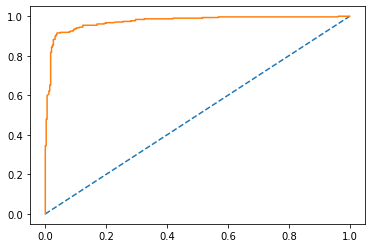

In [ ]:
fpr_3, tpr_3, thresholds_3 = roc_curve(y_test, X_test_predictions_3)
pyplot.plot([0, 1], [0, 1], linestyle = '--')
pyplot.plot(fpr_3, tpr_3)
pyplot.show()

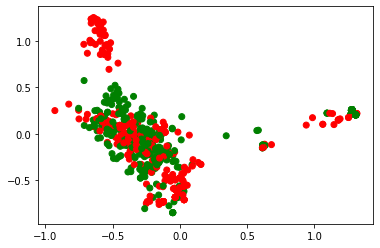

In [ ]:
result = torch.zeros(1, 27016)

for i in H_list_model_2:
    result = torch.cat([result, i.cpu()], 0)

X_result = result.numpy()[1:]

X = X_result / np.max(X_result)
pca = decomposition.PCA(n_components = 2)
X = pca.fit_transform(X)
points = np.arange(X.shape[0])

plt.scatter(X[points, 0], X[points, 1], color = ['red' if l == 1 else 'green' for l in y_test[points]])
plt.savefig('test_4.pdf')
plt.show()

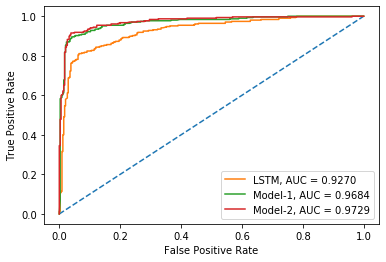

In [ ]:
pyplot.plot([0, 1], [0, 1], linestyle = '--')
auc_1 = roc_auc_score(y_test, X_test_predictions_1)
pyplot.plot(fpr_1, tpr_1, label = f'LSTM, AUC = {auc_1:.4f}')
auc_2 = roc_auc_score(y_test, X_test_predictions_2)
pyplot.plot(fpr_2, tpr_2, label = f'Model-1, AUC = {auc_2:.4f}')
auc_3 = roc_auc_score(y_test, X_test_predictions_3)
pyplot.plot(fpr_3, tpr_3, label = f'Model-2, AUC = {auc_3:.4f}')
plt.legend(loc = 4)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('roc_b.pdf')
pyplot.show()